# Tutorial 2: Vision Module for 2D Perception

In this tutorial, we'll implement a vision module to process 2D images and extract features that will be useful for 3D understanding. We'll use pre-trained models from Hugging Face for this purpose.

## Setup and Dependencies

In [20]:
# Install necessary packages
!pip install transformers torch pillow matplotlib cv2
!pip install timm  # For vision models

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


## Import Libraries

In [7]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

## Load a Sample Image

First, let's load a sample image of a 3D object:

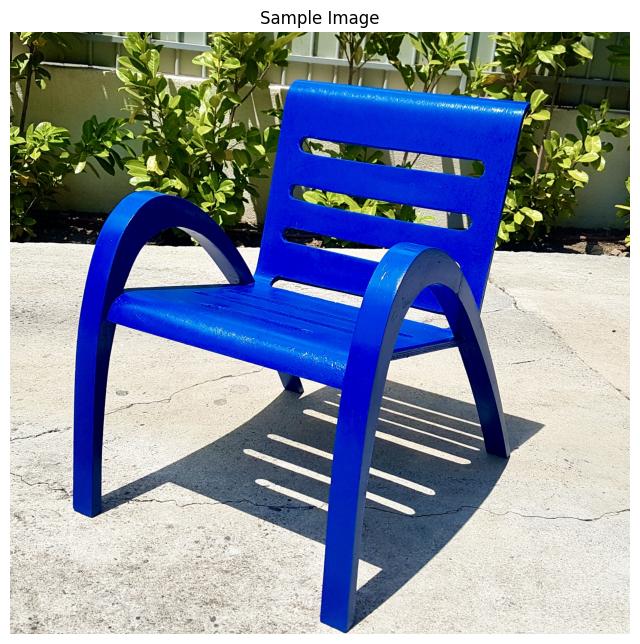

In [14]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Function to load an image from URL with proper headers
def load_image_from_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.google.com/'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        # Check if the response is actually an image
        if 'image' not in response.headers.get('content-type', '').lower():
            raise ValueError('URL does not point to an image')
            
        img = Image.open(BytesIO(response.content))
        return img
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Load a sample image of a chair (using a more reliable URL)
url = "https://upload.wikimedia.org/wikipedia/commons/8/86/Fauteuil_Riviera_Chaise_Bleue_Neptune_SBR.jpg"
image = load_image_from_url(url)

if image:
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Sample Image")
    plt.show()
else:
    print("Failed to load image")

## Load Pre-trained Vision Model

We'll use a pre-trained vision transformer to extract features from the image:


In [16]:
# Load image processor and model (DINO is good for dense feature extraction)
model_name = "facebook/dino-vitb16"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to appropriate device (MPS for Mac Silicon, CPU as fallback)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Extract Visual Features

Now let's extract features from our image:

In [17]:
def extract_features(image, model, processor):
    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # Extract features
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the patch features (excluding the CLS token)
    # Shape: [1, num_patches, hidden_dim]
    features = outputs.last_hidden_state[:, 1:, :]
    
    return features

# Extract features
image_features = extract_features(image, model, processor)
print(f"Feature shape: {image_features.shape}")

Feature shape: torch.Size([1, 196, 768])


## Visualize Attention Maps

To better understand what the model is focusing on, let's visualize attention maps:

Attention maps shape: torch.Size([12, 197, 197])


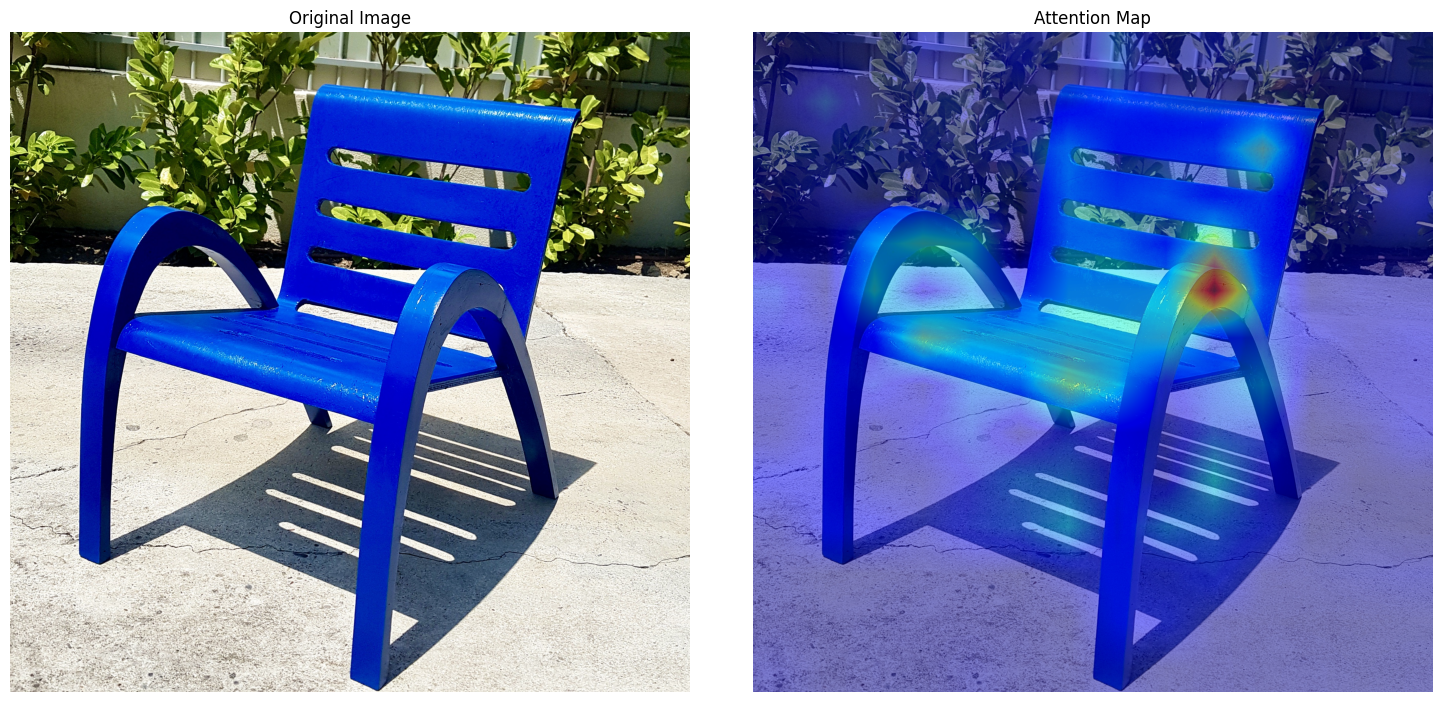

In [22]:
def get_attention_maps(image, model, processor):
    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # Get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get attention from last layer, last head
    # Shape: [1, num_heads, seq_len, seq_len]
    attention = outputs.attentions[-1][0]  # Last layer
    
    return attention

# Get attention maps
# Get attention maps
attention_maps = get_attention_maps(image, model, processor)
print(f"Attention maps shape: {attention_maps.shape}")

# Visualize the attention from the CLS token to the patches
cls_attention = attention_maps.mean(dim=0)[0, 1:]  # Average over heads, CLS token attention

# Calculate the correct patch grid dimensions
num_patches = cls_attention.shape[0]
patch_size = 16  # ViT standard patch size
# Calculate grid dimensions that multiply to give num_patches
import math
grid_size = int(math.sqrt(num_patches))

# Reshape attention to match image patch structure (assuming square grid)
attention_map = cls_attention.reshape(grid_size, grid_size).cpu().numpy()

# Upsample to original image size for visualization
import cv2
attention_map = cv2.resize(attention_map, (image.width, image.height))

# Normalize for visualization
attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

# Plot original image and attention map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(image)
ax2.imshow(attention_map, alpha=0.5, cmap='jet')
ax2.set_title("Attention Map")
ax2.axis('off')

plt.tight_layout()
plt.show()

## Feature Analysis for Depth Understanding

Let's analyze the features to see if we can derive depth information:


Features shape: torch.Size([1, 196, 768])
Number of patches: 196
Calculated grid size: 14x14
Depth features shape before reshape: torch.Size([196])


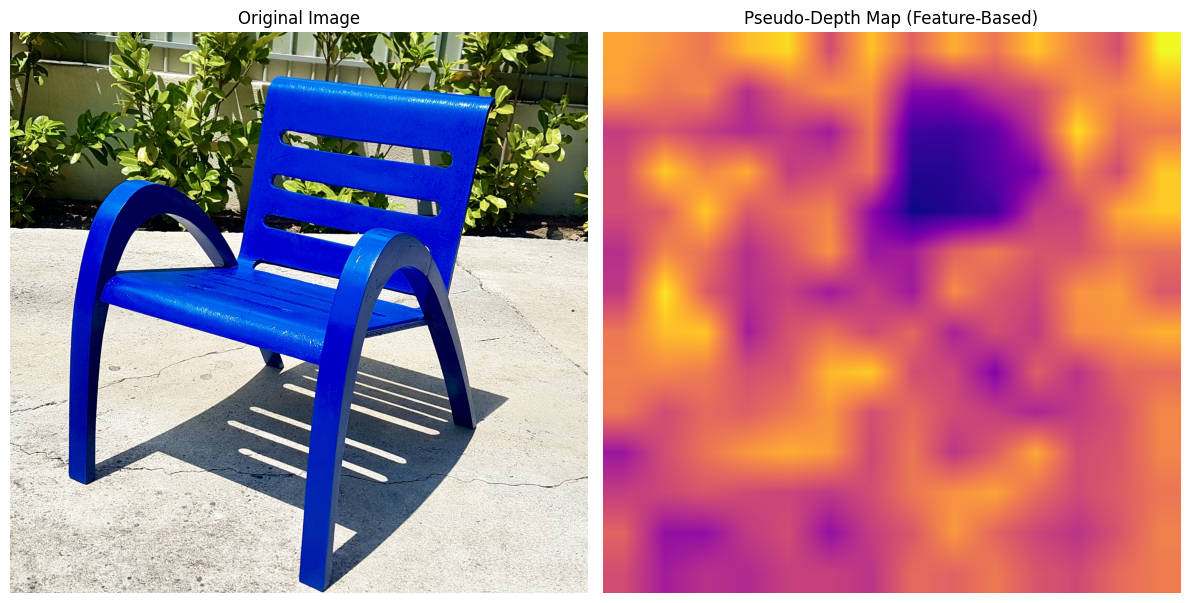

In [27]:
def extract_depth_features(features, image_shape):
    # Debug: print feature shape
    print(f"Features shape: {features.shape}")
    print(f"Number of patches: {features.shape[1]}")
    
    # Calculate expected grid size based on feature count
    import math
    num_patches = features.shape[1]
    grid_size = int(math.sqrt(num_patches))
    print(f"Calculated grid size: {grid_size}x{grid_size}")
    
    # Use the first dimension of features as a simple "depth" proxy
    depth_features = features[0, :, 0]
    print(f"Depth features shape before reshape: {depth_features.shape}")
    
    # Reshape to square grid
    depth_features = depth_features.reshape(grid_size, grid_size)
    
    # Normalize for visualization
    depth_features = (depth_features - depth_features.min()) / (depth_features.max() - depth_features.min())
    
    # Resize to original image size
    depth_map = cv2.resize(depth_features.cpu().numpy(), (image_shape[1], image_shape[0]))
    
    return depth_map

# Extract depth features
image_shape = (image.height, image.width)
depth_map = extract_depth_features(image_features, image_shape)

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap='plasma')
plt.title("Pseudo-Depth Map (Feature-Based)")
plt.axis('off')

plt.tight_layout()
plt.show()

## Integrating with Depth Estimation Model

Let's also integrate a proper depth estimation model for better results:

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


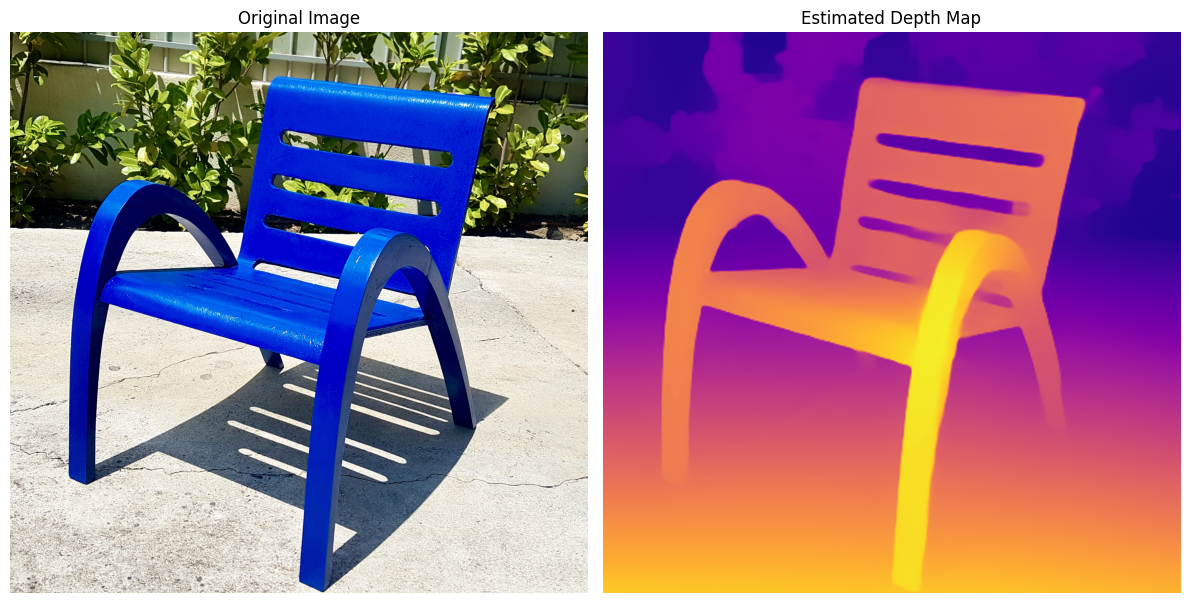

In [28]:
from transformers import DPTForDepthEstimation, DPTImageProcessor

# Load DPT depth estimation model
depth_model_name = "Intel/dpt-large"
depth_processor = DPTImageProcessor.from_pretrained(depth_model_name)
depth_model = DPTForDepthEstimation.from_pretrained(depth_model_name)
depth_model = depth_model.to(device)

# Function to predict depth
def predict_depth(image, model, processor):
    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # Predict depth
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    
    # Interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    
    # Convert to numpy array
    output = prediction.squeeze().cpu().numpy()
    
    # Normalize depth map for visualization
    depth_min = output.min()
    depth_max = output.max()
    normalized_depth = (output - depth_min) / (depth_max - depth_min)
    
    return normalized_depth

# Predict depth
depth_map = predict_depth(image, depth_model, depth_processor)

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap='plasma')
plt.title("Estimated Depth Map")
plt.axis('off')

plt.tight_layout()
plt.show()

## Edge Detection for Structure Understanding

Edge detection can help understand object boundaries and structure:

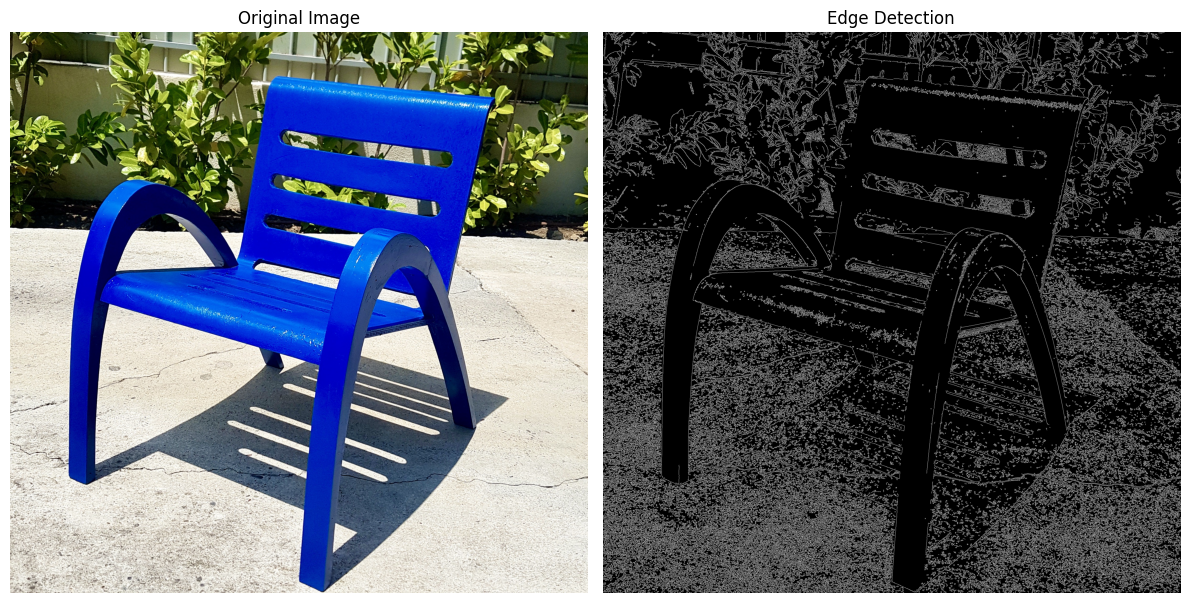

In [29]:
import cv2

def detect_edges(image):
    # Convert PIL image to numpy array
    img_np = np.array(image)
    
    # Convert to grayscale if it's a color image
    if len(img_np.shape) == 3:
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_np
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    
    return edges

# Detect edges
edges = detect_edges(image)

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')

plt.tight_layout()
plt.show()

## Extracting Visual Features in a Format for LLM Integration

Now, let's prepare the extracted visual features to be integrated with our LLM:


In [30]:
def prepare_visual_features_for_llm(image, depth_map, edges):
    """
    Prepare a textual description of visual features for LLM input.
    This is a simplified version for demonstration.
    """
    # Analyze depth map to describe object structure
    # We'll compute some simple statistics
    depth_mean = depth_map.mean()
    depth_std = depth_map.std()
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    
    # Analyze edges to describe object boundaries
    edge_ratio = np.count_nonzero(edges) / edges.size
    
    # Create a textual description
    description = f"""
    Visual Analysis of the Image:
    - Object has a depth profile with relative depth ranging from {depth_min:.2f} to {depth_max:.2f}
    - Average depth is {depth_mean:.2f} with variation of {depth_std:.2f}
    - Edge complexity: {edge_ratio:.2f} (higher means more complex boundaries)
    """
    
    # In a real implementation, you would include more sophisticated analysis
    # such as object part segmentation, viewpoint estimation, etc.
    
    return description

# Prepare visual features for LLM
visual_description = prepare_visual_features_for_llm(image, depth_map, edges)
print(visual_description)


    Visual Analysis of the Image:
    - Object has a depth profile with relative depth ranging from 0.00 to 1.00
    - Average depth is 0.47 with variation of 0.27
    - Edge complexity: 0.14 (higher means more complex boundaries)
    


## Conclusion

In this tutorial, we've implemented a vision module to extract features from 2D images, including:
1. Feature extraction with a vision transformer
2. Attention visualization
3. Depth estimation
4. Edge detection

These features provide valuable information about the 3D structure of objects in 2D images, which we'll integrate with our LLM and symbolic reasoning components in the following tutorials.